# Learning a Repertoire of Robot Arm Configurations with IsoLineEmitter

In this tutorial, we demonstrate how to use MAP-Elites to solve an inverse kinematics problem.

## Overview

Inverse kinematics is an important robotics problem in which, given a final robot configuration, one must figure out the actions to take to accomplish that position. (TODO: update this)

In this example, we will deal with a planar (2D) 12-DoF arm that needs to move its end effector to a certain position. Using MAP-Elites, we will find joint configurations that move the arm to a wide variety of positions.

## Setup

In [1]:
%pip install ribs[all]

Note: you may need to restart the kernel to use updated packages.


In [2]:
import time

import matplotlib.pyplot as plt
import numpy as np

from ribs.archives import CVTArchive
from ribs.emitters import IsoLineEmitter
from ribs.optimizers import Optimizer
from ribs.visualize import cvt_archive_heatmap

## Objective and Behavior Characteristics

In [3]:
def simulate(solutions, joint_lengths):
    """Returns the objective values and BCs for a batch of solutions."""
    n_dim = joint_lengths.shape[0]
    sums = np.mean(solutions, axis=1, keepdims=True)
    objs = -np.sum((solutions - sums) ** 2, axis=1) / n_dim

    cumsum = np.cumsum(solutions, axis=1)
    x_pos = joint_lengths[None] * np.cos(cumsum)
    y_pos = joint_lengths[None] * np.sin(cumsum)
    bcs = np.concatenate(
        (
            np.sum(x_pos, axis=1, keepdims=True),
            np.sum(y_pos, axis=1, keepdims=True),
        ),
        axis=1,
    )

    return objs, bcs

## Running MAP-Elites

TODO: plot archive size and fitness across iters, add in other algos?

In [4]:
dof = 12
joint_lengths = np.ones(dof) / dof
archive = CVTArchive([(-1, 1), (-1, 1)], 10000, use_kd_tree=True)
emitters = [
    IsoLineEmitter(np.zeros(dof),
                   archive,
                   iso_sigma=0.01,
                   line_sigma=0.2,
                   bounds=[(-np.pi, np.pi)] * dof,
                   batch_size=64)
]
opt = Optimizer(archive, emitters)

In [5]:
start_time = time.time()
means = []
itrs = []
for i in range(1500):
    sols = opt.ask()
    objs, bcs = simulate(sols, joint_lengths)

    opt.tell(objs, bcs)

    if (i + 1) % 100 == 0:
        means.append(archive.as_pandas()["objective"].mean())
        itrs.append(i + 1)
        print(f"Finished {i + 1} itrs after {time.time() - start_time} s")

Finished 100 itrs after 0.9854607582092285 s
Finished 200 itrs after 1.5363759994506836 s
Finished 300 itrs after 2.073932409286499 s
Finished 400 itrs after 2.6197421550750732 s
Finished 500 itrs after 3.1488089561462402 s
Finished 600 itrs after 3.693746328353882 s
Finished 700 itrs after 4.238367557525635 s
Finished 800 itrs after 4.782578945159912 s
Finished 900 itrs after 5.325388669967651 s
Finished 1000 itrs after 5.868461608886719 s
Finished 1100 itrs after 6.428823232650757 s
Finished 1200 itrs after 7.026046991348267 s
Finished 1300 itrs after 7.58534836769104 s
Finished 1400 itrs after 8.138923406600952 s
Finished 1500 itrs after 8.684236764907837 s


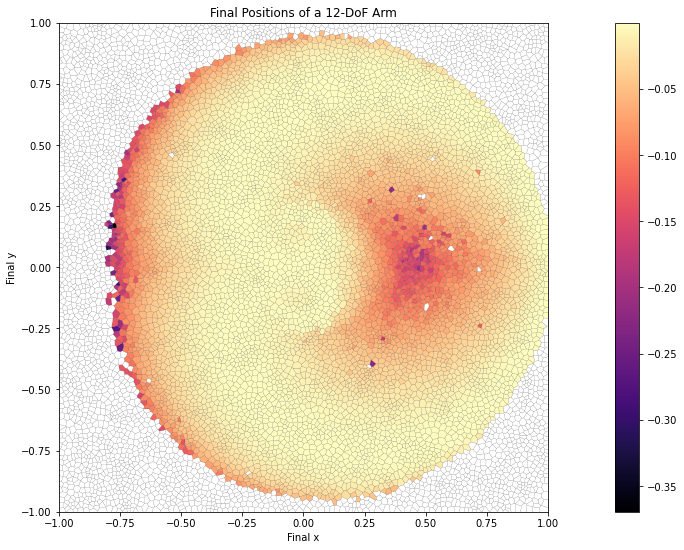

In [6]:
plt.figure(figsize=(12,9))
cvt_archive_heatmap(archive, plot_centroids=False, lw=0.1)
plt.xlabel("Final x")
plt.ylabel("Final y")
plt.title("Final Positions of a 12-DoF Arm");

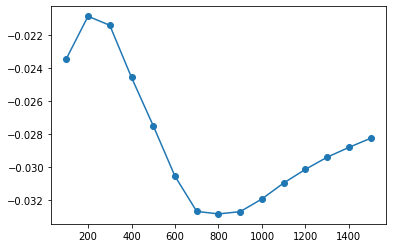

In [7]:
plt.plot(itrs, means, "-o")

## Visualization

Here we visualize several randomly selected elites in the archive.

In [8]:
def visualize(angles, joint_lengths, ax):
    """Plots an arm with the given angles and joint lengths on ax.
    
    angles and joint_lengths are assumed to be the same length.
    """
    ax.set_aspect("equal")
    lim = 1.05 * np.sum(joint_lengths)
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)

    cumsum = np.cumsum(angles)
    pos = np.array([0, 0])
    for i in range(len(angles)):
        next_pos = pos + joint_lengths[i] * np.array(
            [np.cos(cumsum[i]), np.sin(cumsum[i])])
        ax.plot([pos[0], next_pos[0]], [pos[1], next_pos[1]], "-ko", ms=3)
        pos = next_pos
    ax.plot(0, 0, "ro", ms=6)
    final_label = f"Final: ({pos[0]:.2f}, {pos[1]:.2f})"
    ax.plot(pos[0], pos[1], "go", ms=6, label=final_label)
    ax.legend()

-0.034296151264016514 [-0.57002618 -0.40131766]
[-0.61872142 -0.57072676 -0.48126316 -0.42881084 -0.26306775 -0.24715567
 -0.22486522 -0.08505458 -0.02787779 -0.22661114 -0.09176058 -0.20042985]
-0.1425929779129291 [-0.76458786  0.14925658]
[ 1.08292748  0.61754713  0.6075265   0.54754422  0.40062272 -0.02776988
  0.18073759 -0.10419505 -0.19961337  0.31479982 -0.2233702   0.13043819]
-0.0005367405010255709 [-0.22740644 -0.42340713]
[-0.3004896  -0.28846609 -0.34015321 -0.31494995 -0.30808903 -0.35731123
 -0.32428224 -0.32666753 -0.33350267 -0.28305589 -0.35130861 -0.29702198]
-0.002512567079708368 [ 0.03484767 -0.60952306]
[-0.16737718 -0.19598635 -0.20333538 -0.23118291 -0.28506602 -0.25176257
 -0.26668185 -0.32384798 -0.32073695 -0.24663986 -0.32734113 -0.27614563]


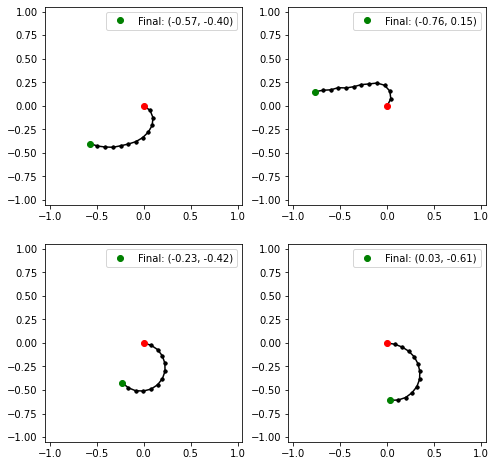

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
ax = ax.flatten()
for i in range(len(ax)):
    solution, objective, behavior = archive.get_random_elite()
    print(objective, behavior)
    print(solution)
    visualize(solution, joint_lengths, ax[i])

## Analyzing Results

Here, we will print out all the solutions we found.

## Conclusion

In this tutorial, we...